In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import math
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, ConfusionMatrixDisplay, roc_auc_score, roc_curve, \
    confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

### Importing the training set and test set

In [5]:
# Loading the datasets
training_set_X = pd.read_csv('training_set_X.csv').to_numpy()
training_set_Y = pd.read_csv('training_set_Y.csv').to_numpy().ravel()
test_set_X = pd.read_csv('test_set_X.csv').to_numpy()
test_set_Y = pd.read_csv('test_set_Y.csv').to_numpy().ravel()

# Save feature names because standardScaler removes them
feature_names = pd.read_csv('LendingClub_processed.csv', nrows=1).columns.tolist()
feature_names.remove('loan_status')
feature_names = np.array(feature_names)

print("Total amount of features: " + str(len(feature_names)))
print("Training set: " + " X: " + str(training_set_X.shape) + ";  Y: "+str(training_set_Y.shape))
print("Test set: " + " X: " + str(test_set_X.shape) + ";  Y: "+str(test_set_Y.shape))

Total amount of features: 53
Training set:  X: (92722, 53);  Y: (92722,)
Test set:  X: (39738, 53);  Y: (39738,)


In [6]:
# Loading the data dictionary
pd.set_option('max_colwidth', 1200) # controls output width; might need adjustment
data_dictionary = pd.read_csv('LCDataDictionary.csv') # Loading in the data dictionary
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name', 'Description': 'description'})

# **A single decision tree model using the 5 most important features**

In [7]:
important_features_5 = [4,1,13,16,0]

# Name descriptions:
important_features_names_5 = list(map(lambda x: feature_names[x], important_features_5))
descriptions_5 = list(map(lambda x: data_dictionary[data_dictionary["name"]==x].description.iloc[0], important_features_names_5))

print('The 5 most important features: ')
important_features_descriptions_5 = pd.DataFrame({'name': important_features_names_5, 'description': descriptions_5})[['name', 'description']]
important_features_descriptions_5

The 5 most important features: 


,name,description
0,sub_grade,LC assigned loan subgrade
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
2,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
3,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
4,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."


In [8]:
# Selecting only the 5 most important features from the datasets:
training_set_X_important_5 = training_set_X[:, important_features_5]
test_set_X_important_5 = test_set_X[:, important_features_5]

print("Datasets shape only considering the 5 most important features: ")
print("Training set: " + " X: " + str(training_set_X_important_5.shape) + ";  Y: "+str(training_set_Y.shape))
print("Test set: " + " X: " + str(test_set_X_important_5.shape) + ";  Y: "+str(test_set_Y.shape))

Datasets shape only considering the 5 most important features: 
Training set:  X: (92722, 5);  Y: (92722,)
Test set:  X: (39738, 5);  Y: (39738,)


### Root node information gain and entropy

In [9]:
def get_entropy(column):
    """
    Computes entropy of a numpy array.
    """
    counts = np.bincount(column)       # Counts of each unique value in the array
    probabilities = counts / len(column)    # probabilities of each unique value

    entropy = 0
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)  # entropy formula
    return -entropy

def entropy_and_information_gain(data, split_column_idx, threshold_value, y_values):
    """
    Computes information gain on a feature to split on.
    """
    entropy_before = get_entropy(y_values)  # initial entropy (before split)

    left_split_indexes = data[:, split_column_idx] <= threshold_value   # 1d np array of indexes that represent values below the threshold
    right_split_indexes = data[:, split_column_idx] > threshold_value   # 1d np array of indexes that represent values above the threshold

    left_node = data[left_split_indexes, split_column_idx]  # (1d np array) column values that are below the threshold
    right_node = data[right_split_indexes, split_column_idx]  # (1d np array) column values that are above the threshold

    left_node_entropy = len(left_node)/len(y_values) * get_entropy(y_values[left_split_indexes])
    right_node_entropy = len(right_node)/len(y_values) * get_entropy(y_values[right_split_indexes])

    entropy_after_split = left_node_entropy + right_node_entropy
    IG = entropy_before - entropy_after_split

    # Return information gain
    return entropy_after_split, IG

def iterative_search(data, feature_names, y_values):
    """
    Finds best threshold (with highest information gain) for each feature in the table
    """
    
    best_entropies = []
    best_thresholds = []
    best_IGs = []

    # go over all columns/features:
    for column in range(data.shape[1]):
        max_IG = float('-inf')
        best_entropy = 1
        best_threshold = 0

        # iterate over different threshold values in the column:
        for threshold in np.unique(data[:, column]):
            E, IG = entropy_and_information_gain(data, column, threshold, y_values)

            # best threshold with highest information gain:
            if IG>max_IG:
                max_IG = IG
                best_threshold = threshold
                best_entropy = E
        
        best_entropies.append(best_entropy)
        best_thresholds.append(best_threshold)
        best_IGs.append(max_IG)

    table_dictionary = {'Feature':feature_names, 'Threshold value':best_thresholds,
                        'Expected entropy':best_entropies, 'Information gain':best_IGs}
    
    hull_table = pd.DataFrame(table_dictionary)

    return hull_table


In [10]:
# Information gain report for the root node:
root_node_info_best_5 = iterative_search(training_set_X_important_5, important_features_names_5, training_set_Y)

root_node_info_best_5

,Feature,Threshold value,Expected entropy,Information gain
0,sub_grade,-0.082786,0.735665,0.039817
1,term,-0.525092,0.757793,0.017689
2,dti,0.122575,0.768440,0.007043
3,fico_range_low,0.311620,0.762919,0.012564
4,loan_amnt,-0.535526,0.772372,0.003110


### The decision tree

Tree accuracy on test set =  0.7732145553374604


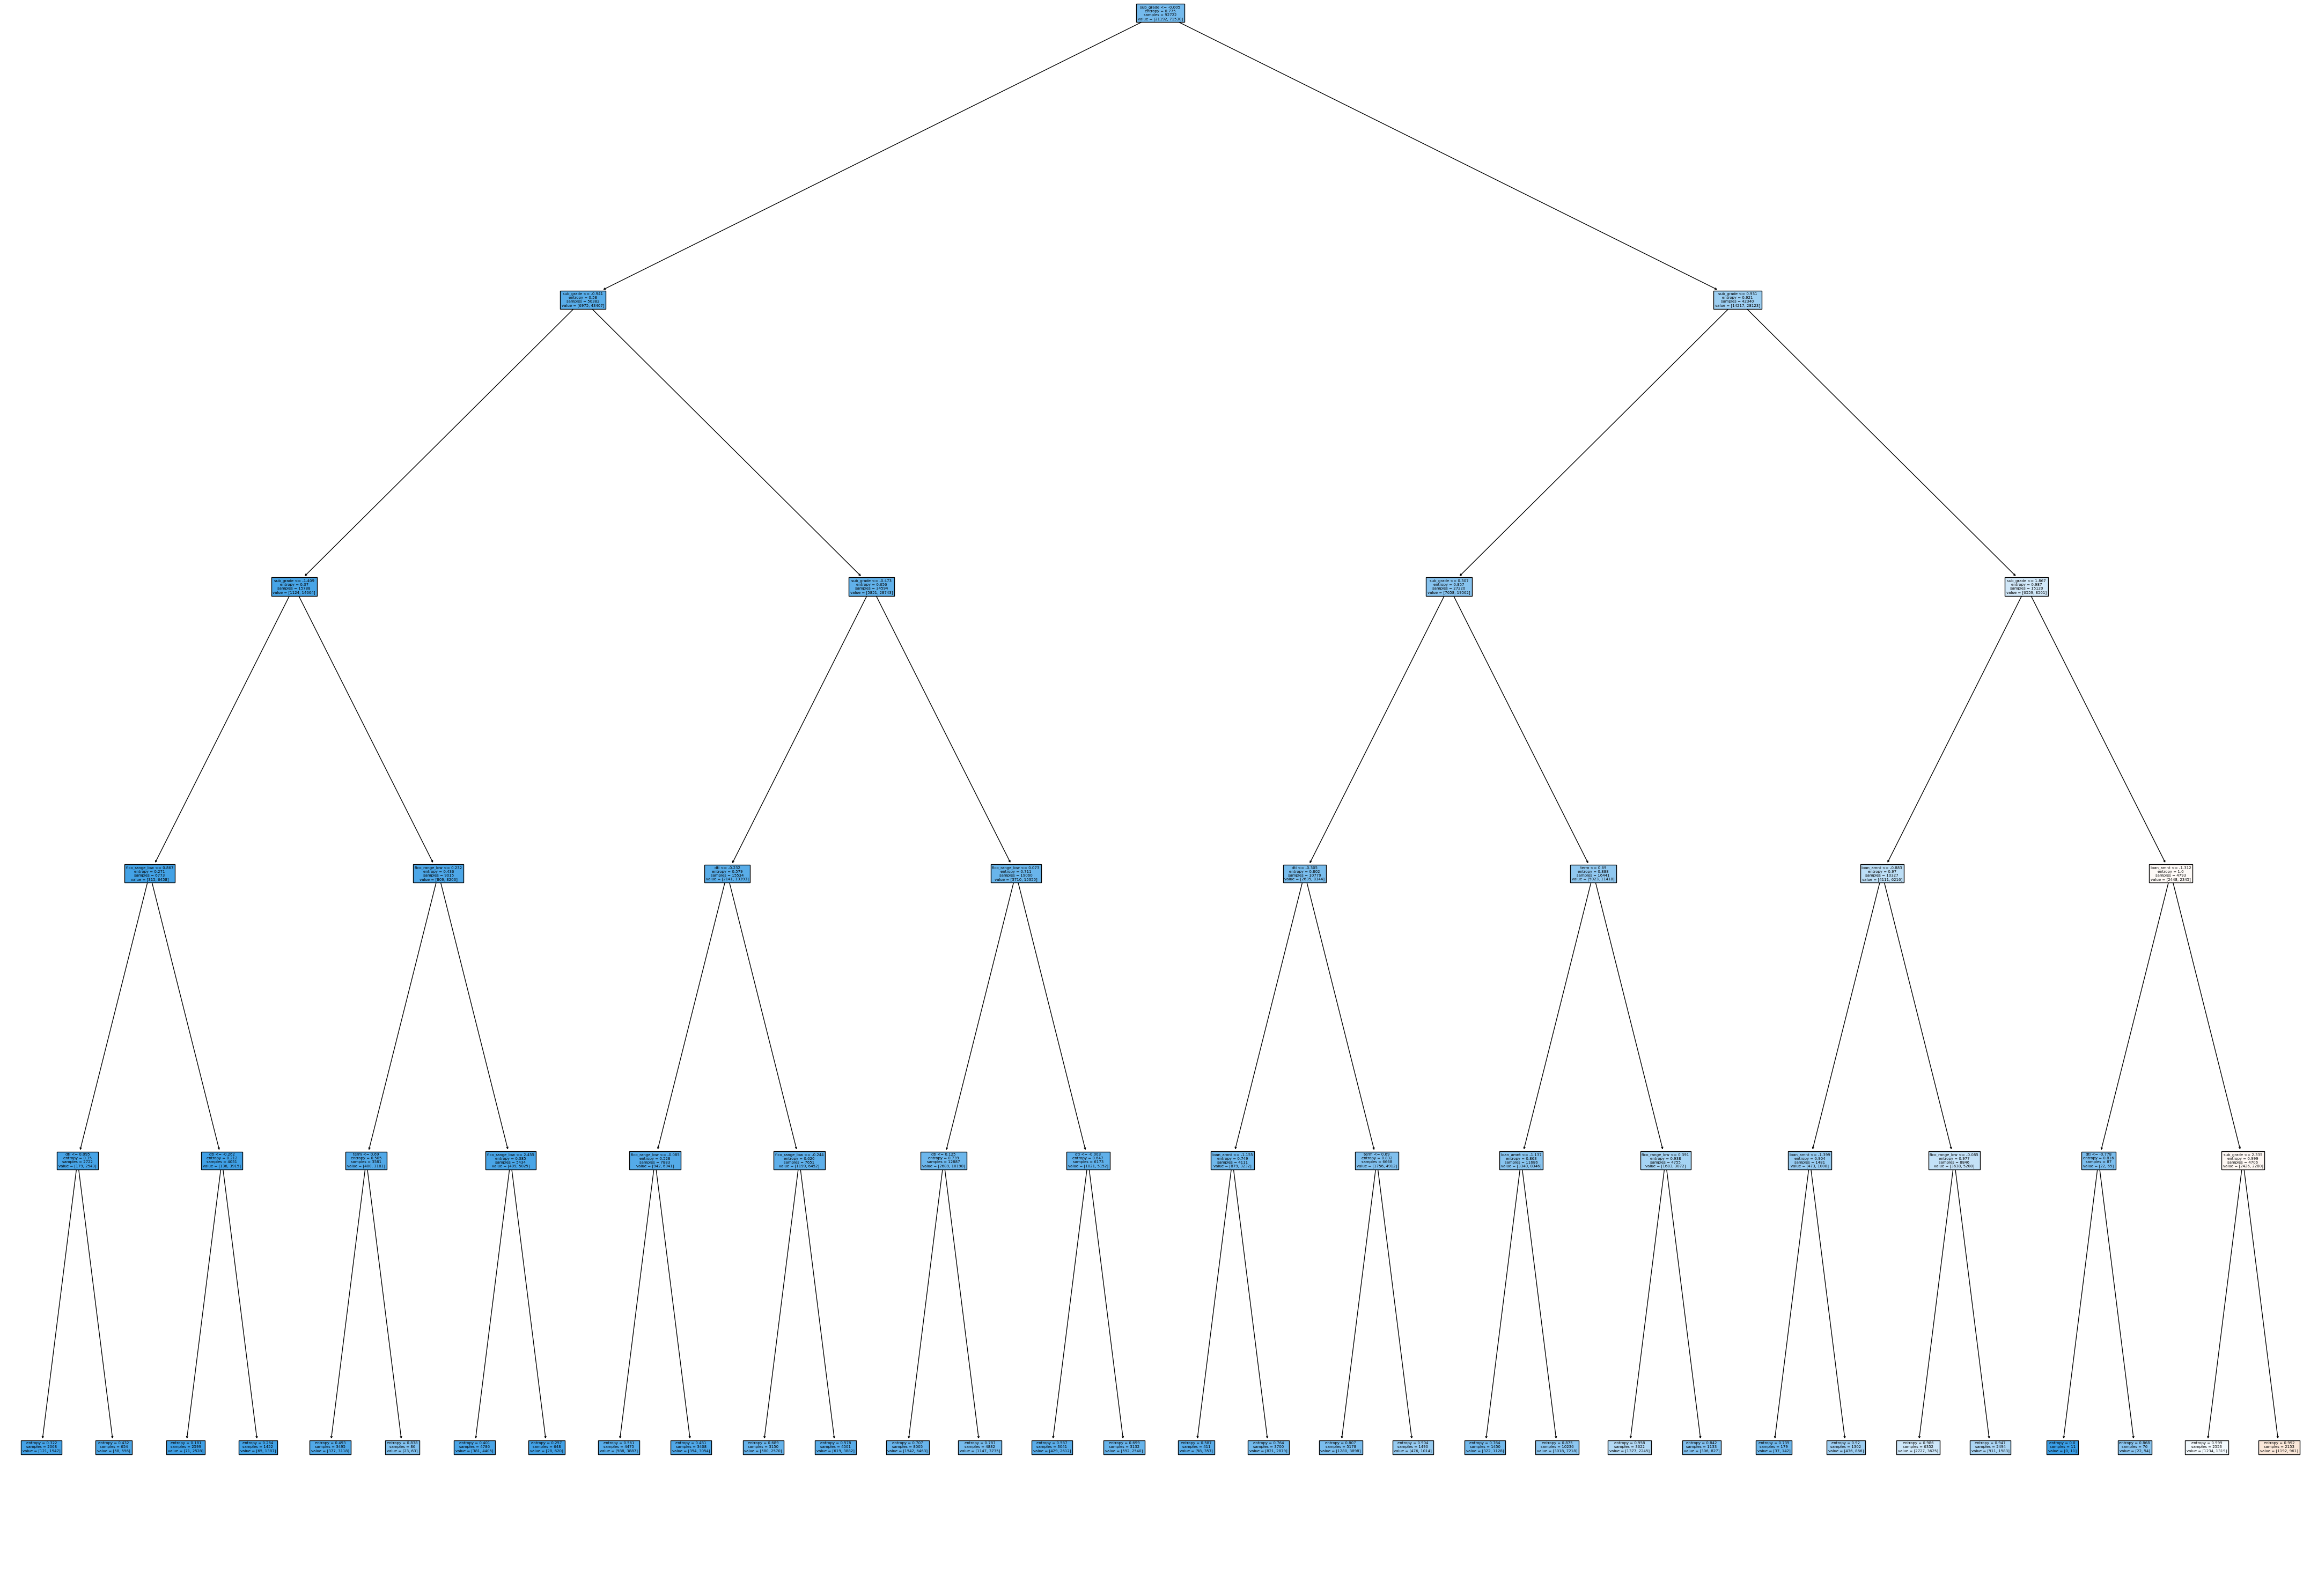

In [11]:
# Decision tree of the best 5 features
decision_tree_best_5 = DecisionTreeClassifier(criterion="entropy", max_depth=5, splitter="best")

decision_tree_best_5 = decision_tree_best_5.fit(training_set_X_important_5, training_set_Y)

print("Tree accuracy on test set = ", decision_tree_best_5.score(test_set_X_important_5, test_set_Y))

fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(decision_tree_best_5, filled=True, feature_names=important_features_names_5, proportion=False)
plt.show()

In [12]:
pd.set_option('display.expand_frame_repr', False)  # printing dataframe width limit

def conf_matrix_and_roc(predict_prob, thresholds):
    """
    Displays confidence matrix and roc curve for a list of thresholds.
    """
    # DF to store results:
    results = pd.DataFrame(
        columns=["THRESHOLD", "accuracy", "true pos rate", "precision", "AUC-score"])
    roc_points = np.zeros((len(thresholds), 2))

    for idx, i in enumerate(thresholds):
        # If prob for test set > threshold predict 1
        preds = np.where(predict_prob > i, 1, 0)

        # create confusion matrix [[TN, FP], [FN, TP]]
        cm = (confusion_matrix(test_set_Y, preds, labels=[0, 1], sample_weight=None) / len(test_set_Y))

        print('Confusion matrix for threshold =', i, '\n', cm, '\n')

        TN, FP, FN, TP = cm.ravel()

        # DF to store results:
        fpr = FP / (FP + TN)
        tpr = recall_score(test_set_Y, preds)
        results['THRESHOLD'] = thresholds
        results.iloc[idx, 1] = accuracy_score(test_set_Y, preds)
        results.iloc[idx, 2] = tpr  # True positive rate
        results.iloc[idx, 3] = precision_score(test_set_Y, preds)
        results.iloc[idx, 4] = roc_auc_score(test_set_Y, preds)  # AUC score

        # Markers on the roc plot
        roc_points[idx, 0] = fpr
        roc_points[idx, 1] = tpr

    print('METRICS:')
    print(results.T)

    # Plot ROC and compute AUC: (part of code taken from the book)
    ns_prob = [0 for _ in range(len(test_set_Y))]
    ns_fpr, ns_tpr, _ = roc_curve(test_set_Y, ns_prob)
    lr_fpr, lr_tpr, _ = roc_curve(test_set_Y, predict_prob)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Tree Model')

    for idx, t in enumerate(thresholds):
        if idx == 0:
            plt.scatter(roc_points[idx, 0], roc_points[idx, 1], color='green', s=50, marker='x', zorder=2,
                        label='Thresholds')
        else:
            plt.scatter(roc_points[idx, 0], roc_points[idx, 1], color='green', s=50, marker='x', zorder=2)
        plt.text(roc_points[idx, 0] - 0.02, roc_points[idx, 1] + 0.02, str(thresholds[idx]))

    plt.title('ROC curve')
    plt.grid(False)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    return

Confusion matrix for threshold = 0.5 
 [[0.01298505 0.21639237]
 [0.01039307 0.7602295 ]] 

Confusion matrix for threshold = 0.6 
 [[0.05561427 0.17376315]
 [0.06223262 0.70838995]] 

Confusion matrix for threshold = 0.7 
 [[0.08996427 0.13941316]
 [0.12552217 0.64510041]] 

Confusion matrix for threshold = 0.75 
 [[0.12574865 0.10362877]
 [0.21246666 0.55815592]] 

Confusion matrix for threshold = 0.8 
 [[0.16608788 0.06328955]
 [0.33741004 0.43321254]] 

Confusion matrix for threshold = 0.85 
 [[0.19384468 0.03553274]
 [0.46295737 0.30766521]] 

METRICS:
                      0         1         2         3         4         5
THRESHOLD           0.5       0.6       0.7      0.75       0.8      0.85
accuracy       0.773215  0.764004  0.735065  0.683905    0.5993   0.50151
true pos rate  0.986513  0.919244  0.837116  0.724292  0.562159  0.399242
precision      0.778428  0.803024  0.822294   0.84341  0.872529  0.896466
AUC-score      0.521562  0.580851  0.614663  0.636255   0.64312  0.

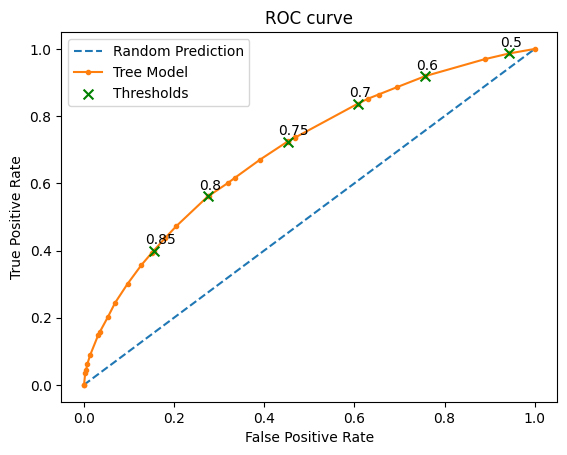

In [13]:
conf_matrix_and_roc(predict_prob = decision_tree_best_5.predict_proba(test_set_X[:, important_features_5])[:,1], thresholds=[.5, .6, .7, .75, .80, .85])

# **Decision tree using the 10 most important features**

In [14]:
important_features_10 = [4,1,0,13,16,39,36,15,32,2]

# Feature names:
important_features_names_10 = list(map(lambda x: feature_names[x], important_features_10))

# Feature descriptions:
descriptions_10 = list(map(lambda x: data_dictionary[data_dictionary["name"]==x].description.iloc[0], important_features_names_10))
important_features_descriptions_10 = pd.DataFrame({'name': important_features_names_10, 'description': descriptions_10})[['name', 'description']]

# Selecting only the 10 most important features from the datasets:
training_set_X_important_10 = training_set_X[:, important_features_10]
test_set_X_important_10 = test_set_X[:, important_features_10]

print("Datasets shape only considering the 10 most important features: ")
print("Training set: " + " X: " + str(training_set_X_important_10.shape) + ";  Y: "+str(training_set_Y.shape))
print("Test set: " + " X: " + str(test_set_X_important_10.shape) + ";  Y: "+str(test_set_Y.shape))

print('\nThe 10 best features: ')
important_features_descriptions_10

Datasets shape only considering the 10 most important features: 
Training set:  X: (92722, 10);  Y: (92722,)
Test set:  X: (39738, 10);  Y: (39738,)

The 10 best features: 


,name,description
0,sub_grade,LC assigned loan subgrade
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
2,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
4,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
5,mort_acc,Number of mortgage accounts.
6,mo_sin_old_rev_tl_op,Months since oldest revolving account opened
7,earliest_cr_line,The month the borrower's earliest reported credit line was opened
8,acc_open_past_24mths,Number of trades opened in past 24 months.
9,int_rate,Interest Rate on the loan


In [15]:
# Information gain report for the root node:
root_node_info_best_10 = iterative_search(training_set_X_important_10, important_features_names_10, training_set_Y)

root_node_info_best_10

,Feature,Threshold value,Expected entropy,Information gain
0,sub_grade,-0.082786,0.735665,0.039817
1,term,-0.525092,0.757793,0.017689
2,loan_amnt,-0.535526,0.772372,0.003110
3,dti,0.122575,0.768440,0.007043
4,fico_range_low,0.311620,0.762919,0.012564
5,mort_acc,-0.315690,0.769228,0.006254
6,mo_sin_old_rev_tl_op,-0.482994,0.772289,0.003193
7,earliest_cr_line,0.324473,0.773879,0.001603
8,acc_open_past_24mths,-0.324224,0.769280,0.006203
9,int_rate,-0.064520,0.735471,0.040011


Tree accuracy on test set =  0.7742463133524586


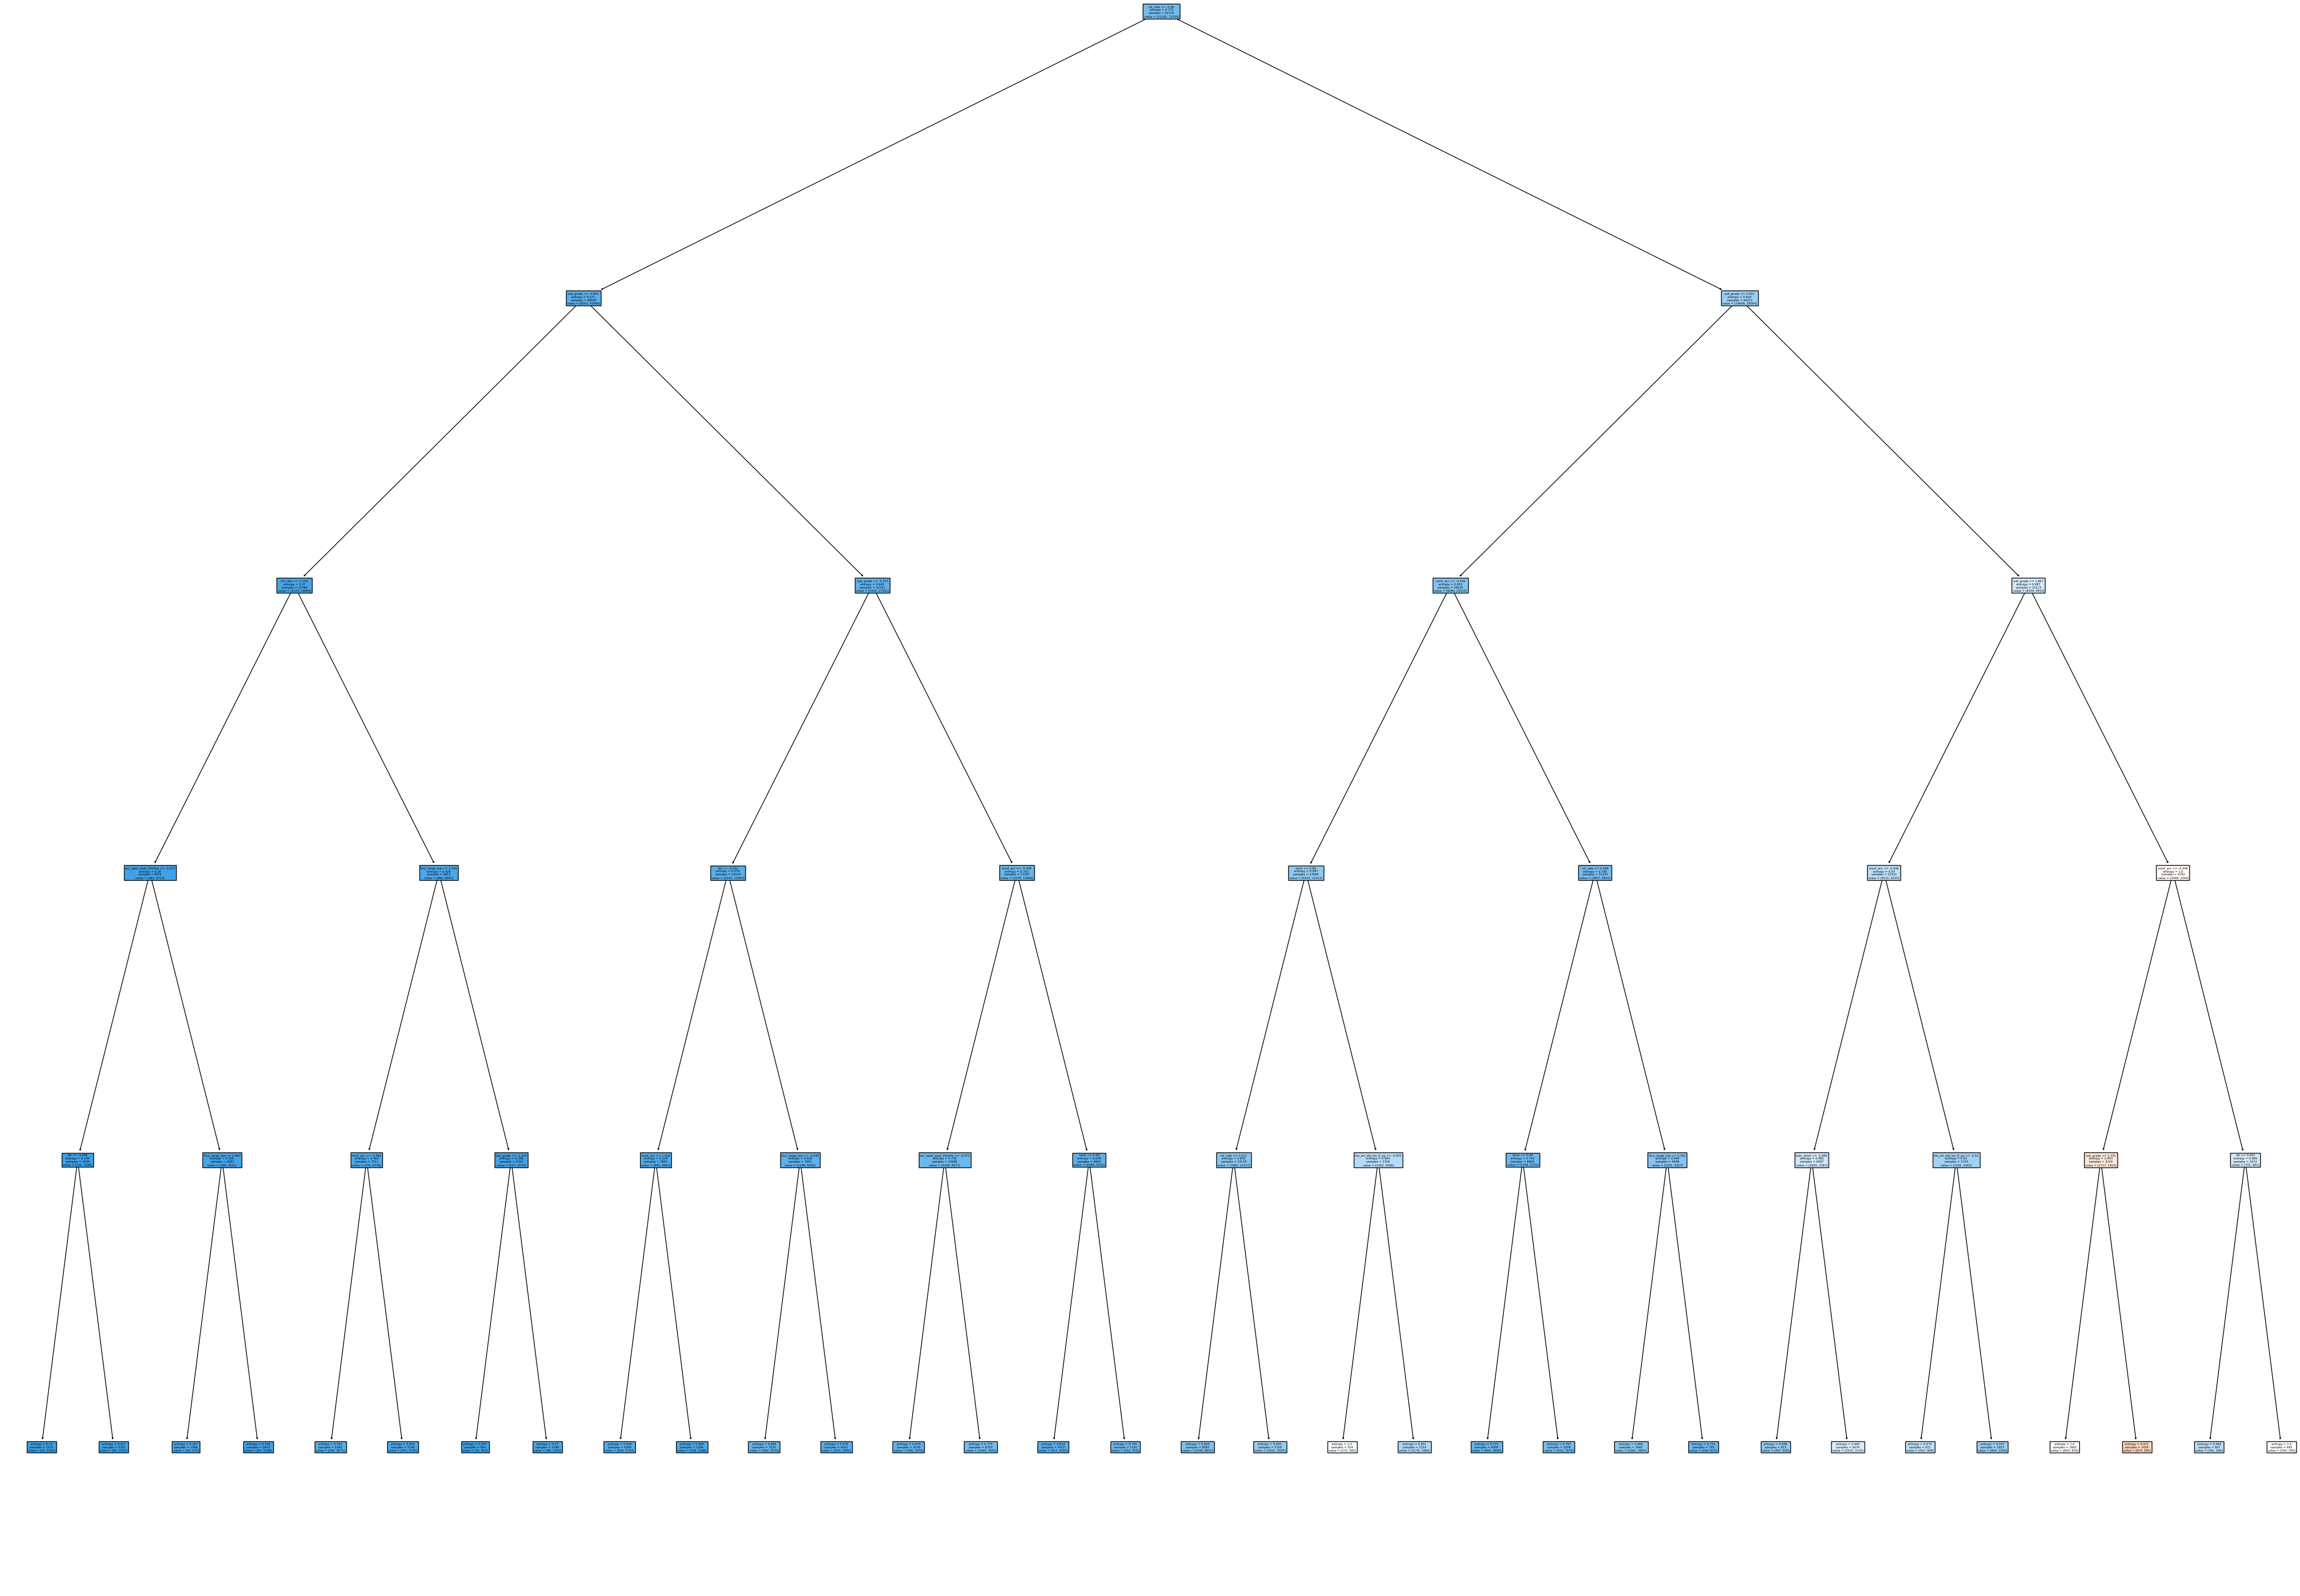

In [16]:
decision_tree_best_10 = DecisionTreeClassifier(criterion="entropy", max_depth=5, splitter="best")

decision_tree_best_10 = decision_tree_best_10.fit(training_set_X_important_10, training_set_Y)

print("Tree accuracy on test set = ", decision_tree_best_10.score(test_set_X_important_10, test_set_Y))

fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(decision_tree_best_10, filled=True, feature_names=important_features_names_10, proportion=False)
plt.show()

Confusion matrix for threshold = 0.5 
 [[0.01801802 0.2113594 ]
 [0.01439428 0.7562283 ]] 

Confusion matrix for threshold = 0.6 
 [[0.05521164 0.17416579]
 [0.06037043 0.71025215]] 

Confusion matrix for threshold = 0.7 
 [[0.10438371 0.12499371]
 [0.1515426  0.61907997]] 

Confusion matrix for threshold = 0.75 
 [[0.14099854 0.08837888]
 [0.25046555 0.52015703]] 

Confusion matrix for threshold = 0.8 
 [[0.16789974 0.06147768]
 [0.34055564 0.43006694]] 

Confusion matrix for threshold = 0.85 
 [[0.2000604  0.02931703]
 [0.49526901 0.27535357]] 

METRICS:
                      0         1         2         3         4         5
THRESHOLD           0.5       0.6       0.7      0.75       0.8      0.85
accuracy       0.774246  0.765464  0.723464  0.661156  0.597967  0.475414
true pos rate  0.981321   0.92166   0.80335  0.674983  0.558077  0.357313
precision       0.78156  0.803073  0.832014  0.854768   0.87493  0.903775
AUC-score      0.529937  0.581181  0.629212  0.644842  0.645029  0.

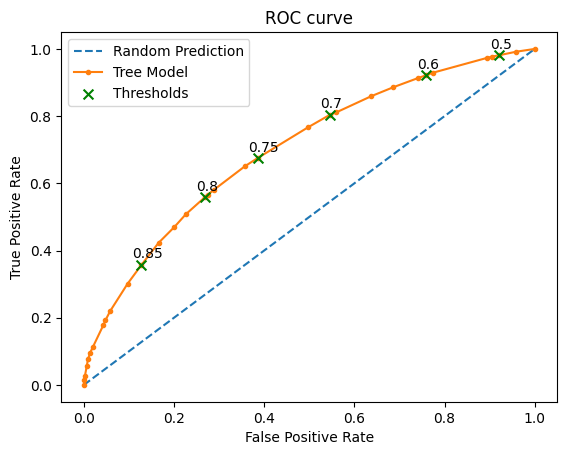

In [17]:
conf_matrix_and_roc(predict_prob = decision_tree_best_10.predict_proba(test_set_X[:, important_features_10])[:,1], thresholds=[.5, .6, .7, .75, .80, .85])

# **Random forest model**

**Optimizing the model by changing max_depth and max_features**

In [3]:
random_forest = RandomForestClassifier(criterion='entropy',oob_score=True,max_samples=0.3,max_depth=5)

oob_errors = []
test_errors = []
max_depths = [10, 12, 16, 20]
max_nr_features = [0.3, 0.5]

for depth in max_depths:

    random_forest.set_params(max_depth=depth)

    for features in max_nr_features:

        random_forest.set_params(max_features=features)

        random_forest.fit(training_set_X, training_set_Y)

        print('Max Depth = ',depth, '; ', 'Max features = ', features, '; ', 'Accuracy on test data = ',random_forest.score(test_set_X, test_set_Y))

        oob_errors.append(1 - random_forest.oob_score_)
        test_errors.append(1 - random_forest.score(test_set_X, test_set_Y))

Max Depth =  10 ;  Max features =  0.3 ;  Accuracy on test data =  0.7779455433086718
Max Depth =  10 ;  Max features =  0.5 ;  Accuracy on test data =  0.7787004881976949
Max Depth =  12 ;  Max features =  0.3 ;  Accuracy on test data =  0.7779707081383059
Max Depth =  12 ;  Max features =  0.5 ;  Accuracy on test data =  0.7778952136494036
Max Depth =  16 ;  Max features =  0.3 ;  Accuracy on test data =  0.7776184005234285


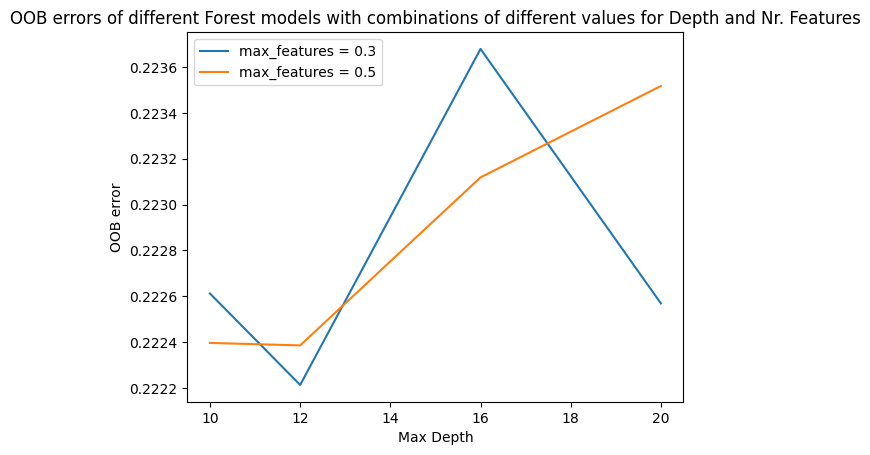

In [16]:
plt.plot(max_depths, [oob_errors[0], oob_errors[2], oob_errors[4], oob_errors[6]])
plt.plot(max_depths, [oob_errors[1], oob_errors[3], oob_errors[5], oob_errors[7]])
plt.legend(['max_features = 0.3', 'max_features = 0.5'])
plt.title("OOB errors of different Forest models with combinations of different values for Depth and Nr. Features")
plt.xlabel("Max Depth")
plt.ylabel("OOB error")
plt.show()

**Optimizing the model by changing the number of trees (n_estimator)**

In [17]:
nr_estimators = [100, 110, 120, 130]
nr_trees_errors = []

random_forest.set_params(max_depth=16, max_features=0.3)

for estimator in nr_estimators:

    random_forest.set_params(n_estimators=estimator)

    random_forest.fit(training_set_X, training_set_Y)

    nr_trees_errors.append(1 - random_forest.score(test_set_X, test_set_Y))

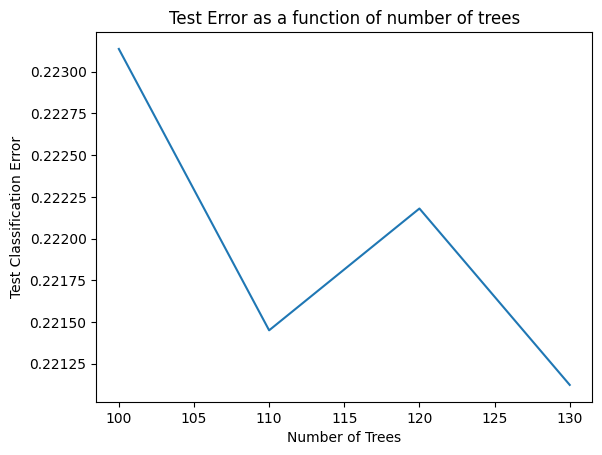

In [18]:
plt.plot(nr_estimators, nr_trees_errors)
plt.title("Test Error as a function of number of trees")
plt.xlabel("Number of Trees")
plt.ylabel("Test Classification Error")
plt.show()

**Best Forest Model**

In [2]:
random_forest.set_params(max_depth=12, max_features=0.3, n_estimators=120)
random_forest.fit(training_set_X, training_set_Y)

print("OOB error for best model = ", 1 - random_forest.oob_score_,'; Test error for best model = ', 1 - random_forest.score(test_set_X, test_set_Y))

# Finding the top 10 most important features:
important_features_forest = random_forest.feature_importances_.tolist()
aux = copy.deepcopy(important_features_forest)
important_features_values = []
important_features_index = []
most_important = 0

for i in range(10):
    max_value = max(aux)
    if i == 0:
        most_important = max_value
    max_value_index= important_features_forest.index(max_value)
    print('Feature: ' + str(max_value_index) + '  Weight: ' + str(max_value))

    important_features_values.append(max_value / most_important * 100)
    important_features_index.append(max_value_index)
    del aux[aux.index(max_value)]

# Get the original feature names instead of plain numbers:
important_features_forest_names = list(map(lambda x: feature_names[x], important_features_index))
print("\nMost important features: " + str(important_features_forest_names))

NameError: NameError: name 'random_forest' is not defined

In [1]:
important_features_forest_names.reverse()
important_features_values.reverse()

plt.barh(important_features_forest_names, important_features_values)
plt.title("Variable Importance")
plt.xlabel("Variable Importance")
plt.ylabel("Features")
plt.show()

NameError: NameError: name 'important_features_forest_names' is not defined

## Best model confusion matrix, ROC and other metrics

Confusion matrix for threshold = 0.5 
 [[0.0232523  0.20612512]
 [0.01608033 0.75454225]] 

Confusion matrix for threshold = 0.6 
 [[0.05959032 0.16978711]
 [0.05848306 0.71213951]] 

Confusion matrix for threshold = 0.7 
 [[0.1122603  0.11711712]
 [0.1602748  0.61034778]] 

Confusion matrix for threshold = 0.75 
 [[0.14487392 0.0845035 ]
 [0.24538225 0.52524032]] 

Confusion matrix for threshold = 0.8 
 [[0.17572601 0.05365142]
 [0.35489959 0.41572299]] 

Confusion matrix for threshold = 0.85 
 [[0.20194776 0.02742966]
 [0.48902813 0.28159444]] 

METRICS:
                      0         1         2         3         4         5
THRESHOLD           0.5       0.6       0.7      0.75       0.8      0.85
accuracy       0.777795   0.77173  0.722608  0.670114  0.591449  0.483542
true pos rate  0.979133  0.924109  0.792019  0.681579  0.539464  0.365412
precision      0.785435  0.807482  0.839007  0.861411  0.885696  0.911238
AUC-score      0.540252   0.59195  0.640716  0.656588  0.652782  0.

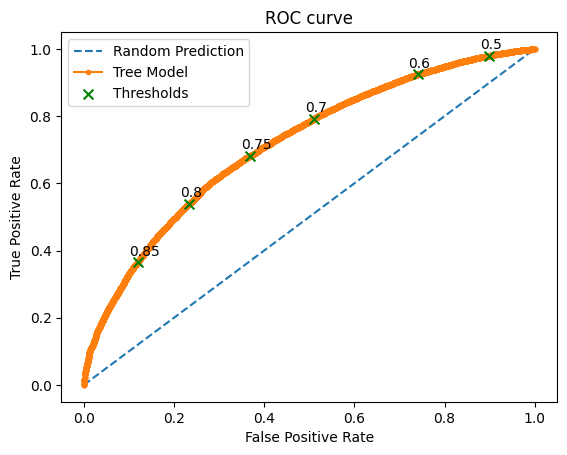

In [21]:
# Performance of the model for different thresholds
conf_matrix_and_roc(predict_prob = random_forest.predict_proba(test_set_X)[:,1], thresholds=[.5, .6, .7, .75, .80, .85])

In [22]:
# AUC comparison for different thresholds:
thresholds=[.5, .6, .7, .75, .80, .85]
pred_proba = random_forest.predict_proba(test_set_X)[:,1]

auc_results = pd.DataFrame(columns = ['Threshold', 'Random forest model'])
auc_results['Threshold'] = thresholds

for idx, t in enumerate(thresholds):
    auc_results.iloc[idx,1] = roc_auc_score(test_set_Y, np.where(pred_proba > t, 1, 0))

print("AUC comparison for different thresholds:")
print(auc_results.T)

AUC comparison for different thresholds:
                            0        1         2         3         4         5
Threshold                 0.5      0.6       0.7      0.75       0.8      0.85
Random forest model  0.540252  0.59195  0.640716  0.656588  0.652782  0.622914


### Performance of the model when the probability threshold is set to 0.75

In [23]:
proba_threshold = 0.75
predictions_test_set = np.where(random_forest.predict_proba(test_set_X)[:,1] > proba_threshold, 1, 0)

cm = (confusion_matrix(test_set_Y, predictions_test_set, labels=[0, 1], sample_weight=None) / len(test_set_Y))
print('Confusion matrix of the best random forest model:\n', cm, '\n')

rf_metrics_dictionary = {"accuracy": [accuracy_score(test_set_Y, predictions_test_set)], 
                      "true pos rate": [recall_score(test_set_Y, predictions_test_set)], 
                     "precision": [precision_score(test_set_Y, predictions_test_set)], 
                     "AUC-score": [roc_auc_score(test_set_Y, predictions_test_set)]}
rf_metrics = pd.DataFrame(rf_metrics_dictionary)
rf_metrics

Confusion matrix of the best random forest model:
 [[0.14487392 0.0845035 ]
 [0.24538225 0.52524032]] 



,accuracy,true pos rate,precision,AUC-score
0,0.670114,0.681579,0.861411,0.656588
